In [1]:
import h5py

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from rfest import splineLG
from rfest import get_stimulus_design_matrix, get_spatial_and_temporal_filters

In [2]:
# Plotting helper 
def plot_RF(k, dims, title=''):
    
    import matplotlib.gridspec as gridspec
    
    k_norm = k / np.linalg.norm(k)
    
    sRF, tRF = get_spatial_and_temporal_filters(k_norm, dims)
    
    fig = plt.figure(figsize=(7,6))
    spec = gridspec.GridSpec(ncols=5, nrows=3, figure=fig)
    ax0 = fig.add_subplot(spec[:2, :2])
    ax0.imshow(sRF, origin='lower', cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
    ax0.set_title('Spatial filter')
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax1 = fig.add_subplot(spec[:2, 2:])
    
    labels = ['-800', '-600', '-400', '-200', '0 ms']
    ax1.plot(labels, tRF, 'ko-')
    ax1.set_ylim(-0.8, 0.8)
    ax1.set_title('Temporal filter')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    
    
    for i in range(dims[0]):
        ax = fig.add_subplot(spec[2, i])
        ax.imshow(k_norm.reshape(dims)[i], origin='lower', cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
        ax.set_title(labels[i])
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.suptitle(title, fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Load RGC calcium imaging data

In [3]:
with h5py.File('./data/RGC_dendrite.h5', 'r') as f:
    
    stimulus = np.array(f['stimulus'])
    response = np.array(f['response']) 
    
print("# rois = {}".format(response.shape[0]))

# rois = 19


In [4]:
roi_id = 0
dims = [5, 20, 15]
X = get_stimulus_design_matrix(stimulus, dims[0])
y = response[roi_id] 

# Receptive Field Estimation with Natural Cubic Regression Spline

Raw STA, raw maximum likelihood and spline-based maximum likelihood are calculated for free when `splineLG` class is initialized. Call `splineLG().fit()` to get least-square estimation with ElasticNet (`alpha` control the balance between L1 and L2 regularization, `lambda` control the overall weight of the regularization term).

In [5]:
cr = splineLG(X, y, dims, df=7, smooth='cr', compute_mle=True)
cr.fit(num_iters=1500, alpha=1, lambd=0.03, verbal=100) # verbal=0: no progress; 
                                                        # verbal=n: print progress at every n steps

/Users/ziweih/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/jax/lib/xla_bridge.py:114: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Iter	Cost	
0	121.373	
100	121.203	
200	121.137	
300	121.055	
400	120.957	
500	120.843	
600	120.713	
700	120.569	
800	120.410	
900	120.235	
1000	120.045	
1100	119.840	
1200	119.618	
1300	119.382	
1400	119.131	
Stop at 1499 steps: cost has been monotonically increasing for 10 steps.


# Receptive Field Estimation with Thin Plate Regression Spline


In [6]:
tp = splineLG(X, y, dims, df=7, smooth='tp', compute_mle=True)
tp.fit(num_iters=1500, alpha=1, lambd=0.03, verbal=100) # verbal=0: no progress; 
                                                        # verbal=n: print progress at every n steps

Iter	Cost	
0	5646629.514	
100	5646619.224	
200	5646608.934	
300	5646598.644	
400	5646588.354	
500	5646578.064	
600	5646567.774	
700	5646557.484	
800	5646547.194	
900	5646536.904	
1000	5646526.614	
1100	5646516.324	
1200	5646506.034	
1300	5646495.744	
1400	5646485.454	
Stop: reached 1500 steps, final cost=5646475.26715.


### Plot Results

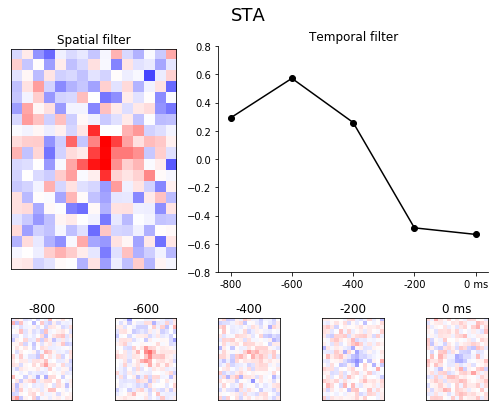

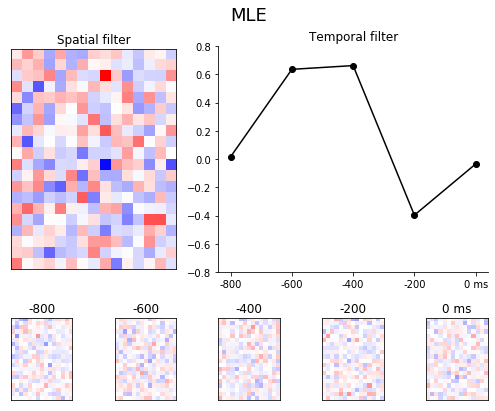

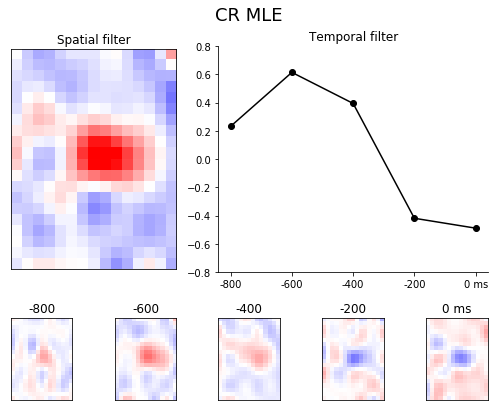

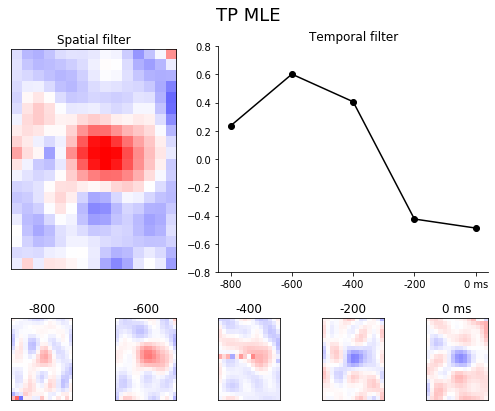

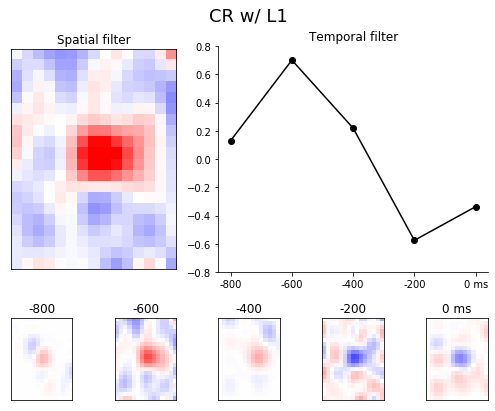

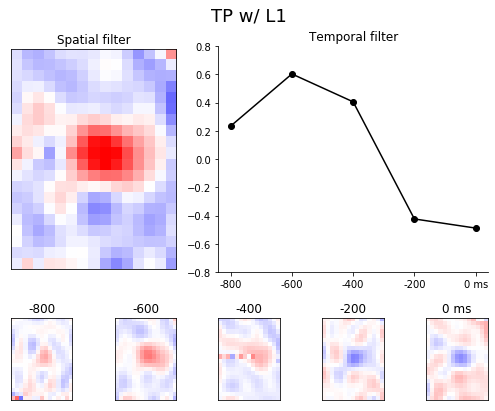

In [7]:
plot_RF(tp.w_sta, dims, 'STA')
plot_RF(tp.w_mle, dims, 'MLE')
plot_RF(cr.w_spl, dims, 'CR MLE')
plot_RF(tp.w_spl, dims, 'TP MLE')
plot_RF(cr.w_opt, dims, 'CR w/ L1')
plot_RF(tp.w_opt, dims, 'TP w/ L1')

In [8]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [10]:
type(cr.X), type(cr.y), type(cr.S)

(jax.interpreters.xla.DeviceArray,
 jax.interpreters.xla.DeviceArray,
 jax.interpreters.xla.DeviceArray)

In [16]:
cr.w_mle

DeviceArray([ 0.0879143 , -0.13861169, -0.0903968 , ..., -0.61138847,
             -0.12274328, -1.84432478])